In [ ]:
import numpy as np
# Age Income Student Credit Rating Buy Computer
# 25 High No Fair No
# 30 High No Excellent No
# 35 Medium No Fair Yes
# 40 Low No Fair Yes
# 45 Low Yes Fair Yes
# 50 Low Yes Excellent No
# 55 Medium Yes Excellent Yes
# 60 High No Fair No

class TreeNode:
    def __init__(self,feature=None,threshold=None,left=None,right=None,*,value=None):
        self.feature=feature
        self.threshold=threshold
        self.left=left
        self.right=right
        self.value=value
        
    def leaf_node(self):
        return self.value    

In [1]:
   
class DecisionTree:
    def __init__(self, min_samplescurrentsplitting=2, max_depth=3, n_features=None):
        self.min_samplescurrentsplitting=min_samplescurrentsplitting
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None
        self.feature_types = None 

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.feature_types = [self._is_categorical(X[:, i]) for i in range(X.shape[1])]
        self.root = self._grow_tree(X, y)

    def _is_categorical(self, column):
       
        if isinstance(column[0], str):
            return True
        unique_values = np.unique(column)
        if len(unique_values) < 0.2 * len(column) and len(unique_values) < 10:
            return True
        return False
    

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # print(f"Depth {depth}: {n_samples} samples, {n_labels} unique labels")
        # print("X:\n", X)
        # print("y:", y)
        # print("-" * 50)

        # check the stopping criteria
        if (depth>=self.max_depth or n_samples<self.min_samplescurrentsplitting):
            leaf_value = self.current_comm_label(y)
            # print(f"Stopping Condition: depth={depth}, max_depth={self.max_depth}, n_labels={n_labels}, n_samples={n_samples}")
            return TreeNode(value=leaf_value)

        # feat_idxs = range(n_feats)
        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self.bestcurrentsplitting(X, y, feat_idxs)
        if best_feature is None:
            leaf_value = self.current_comm_label(y)
            return TreeNode(value=leaf_value)
        

        # if depth <= 5:
            # print(f"Level {depth} Split: Feature = {best_feature}, Threshold = {best_thresh}")
            
        
        # create child nodes
        left_idxs, right_idxs = self.currentsplitting(X[:, best_feature], best_thresh,self.feature_types[best_feature])
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        # print(best_thresh)
        # print(best_feature)
        return TreeNode(feature=best_feature,threshold= best_thresh, left=left, right=right)

    def current_comm_label(self, y):
    
        if len(y) == 0:
            return None
        counts = np.bincount(y)
        return np.argmax(counts)

    def bestcurrentsplitting(self,X,Y,features):
        best_red=-1
        split_index,split_threshold=None,None 
        for feat in features:
            X_col=X[:,feat]     
            thresholds=np.unique(X_col)

            for threshs in thresholds:
                #calc the impurity --> 1-sum p^2
                reduction = self.gini_impurity(Y,X_col,threshs,self.feature_types[feat])
                if reduction>best_red:
                    best_red=reduction
                    split_index=feat
                    split_threshold=threshs

        return (split_index,split_threshold) if best_red>0 else (None,None)
    
    # def bestcurrentsplitting(self, X, Y, features):
    #     best_red = -1
    #     split_index, split_threshold = None, None 

    #     for feat in features:
    #         X_col = X[:, feat]     
    #         thresholds = np.unique(X_col)

    #         for threshs in thresholds:
    #             reduction = self.gini_impurity(Y, X_col, threshs, self.feature_types[feat])

    #             # Changed condition to accept any improvement
    #             if reduction >= best_red or best_red == -1:
    #                 best_red = reduction
    #                 split_index = feat
    #                 split_threshold = threshs

    #     # Return best found split regardless of reduction amount
    #     return (split_index, split_threshold) if split_index is not None else (None, None)
    
    def gini_impurity(self,Y,Column, threshold,is_categorical):
        #parent gininindex 
        parent_gini=self.gini(Y)   

        left_feats,right_feats = self.currentsplitting(Column,threshold,is_categorical) 

        if len(left_feats) == 0 or len(right_feats) == 0:
            return 0   
        
        #weightedgini
        n=len(Y)
        num_left,num_right=len(left_feats),len(right_feats)
        gini_left,gini_right=self.gini(Y[left_feats]),self.gini(Y[right_feats])

        weighted_gini = (num_left / n) * gini_left + (num_right / n) * gini_right
        gini_reduction = parent_gini - weighted_gini
        
        return gini_reduction


    def gini(self, Y):
        if len(Y) == 0:
            return 0
        counts = np.bincount(Y)
        probs = counts / len(Y)
        return 1 - np.sum(probs**2)
    
    def currentsplitting(self, Col, thr,is_categorical):
        if is_categorical:
            # Split categorical data by equality
            left_feat = np.argwhere(Col == thr).flatten()
            right_feat = np.argwhere(Col != thr).flatten()
        else:
            # Split numerical data as usual
            left_feat = np.argwhere(Col <= thr).flatten()
            right_feat = np.argwhere(Col > thr).flatten()

        return left_feat, right_feat

        
    def gini(self,Y):
        tot_label=np.bincount(Y)
        ps=tot_label/len(Y)

        #gini impurity is 1-sum of pi^2
        gini_imp = 1 - np.sum([p**2 for p in ps ])

        return gini_imp
    
    def predict(self,X):
        return  np.array([self.traverse(x,self.root) for x in X])

    def traverse(self, x, node):
   
    # print(f"Node: {node.feature}, Threshold: {node.threshold}, Value: {node.value}")

        if node.value is not None:
            # print(f"Reached leaf: {node.value}")
            return node.value

        feature_val = x[node.feature]

        if self.feature_types[node.feature]:
            # Categorical feature
            if feature_val == node.threshold:
                # print(f"Feature {node.feature} ({feature_val}) == Threshold ({node.threshold}) ->Left")
                return self.traverse(x, node.left)
            else:
                # print(f"Feature {node.feature} ({feature_val}) != Threshold ({node.threshold}) -> Right")
                return self.traverse(x, node.right)
        else:
            # Numerical feature
            if feature_val <= node.threshold:
                # print(f"Feature {node.feature} ({feature_val}) <= Threshold ({node.threshold}) -> Left")
                return self.traverse(x, node.left)
            else:
                # print(f"Feature {node.feature} ({feature_val}) > Threshold ({node.threshold}) ->Right")
                return self.traverse(x, node.right)
            


In [2]:
import numpy as np
from DecisionTree import DecisionTree

class BaggedDecisionTrees:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=20,n_features=None,seed_state=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []
        self.n_features=n_features
        self.feature_subsets=[]
        self.OOBerror = None
        self.seed_state=seed_state
        # if self.seed_state is not None:
        #     np.random.seed(self.seed_state)
        # else: 
        #     np.random.seed(10)    
            

    def fit(self, X, y):
        self.feature_subsets=[]

        n_samples = X.shape[0]
        n_total_features=X.shape[1]

        oob_predictions = np.zeros((n_samples,))
        oob_counts = np.zeros((n_samples,))

        for _ in range(self.n_trees):

            #bootstrap 
            features_index = np.random.choice(n_samples,n_samples,replace=True)
            X_sample, y_sample = X[features_index], y[features_index]

            #select random subsets
            if self.n_features is not None: 
                chosen_feature = np.random.choice(n_total_features,self.n_features,replace=False)
                X_Subset = X_sample[:,chosen_feature]
            else:
                chosen_feature = np.arange(n_total_features)
                X_Subset=X_sample    


            tree = DecisionTree( max_depth=self.max_depth,min_samplescurrentsplitting=self.min_samples_split)
            tree.fit(X_Subset, y_sample)
            self.trees.append(tree)
            self.feature_subsets.append(chosen_feature)


            #OOB calc 
            oob_values = ~np.isin(np.arange(n_samples),features_index)
            oob_indices = np.where(oob_values)[0]

            if(len(oob_indices)>0):
                X_Oob = X[oob_indices][:,chosen_feature]
                oob_preds = tree.predict(X_Oob)

                oob_predictions[oob_indices] += oob_preds
                oob_counts[oob_indices] += 1

        valid_oob_mask = oob_counts > 0

        if np.any(valid_oob_mask):
            y_oob = y[valid_oob_mask]
            pred_oob = (oob_predictions[valid_oob_mask] / oob_counts[valid_oob_mask]) >= 0.5
            self.OOBerror = np.mean(pred_oob != y_oob)
        else:
            self.OOBerror = None 


    def predict(self,X):
        all_predictions=[]
        for tree,feature_index in zip(self.trees,self.feature_subsets):
            X_subset = X[:,feature_index]       
            preds = tree.predict(X_subset) 
            all_predictions.append(preds)
        return np.array(all_predictions).mean(axis=0) >= 0.5  

In [3]:
from DecisionTree import DecisionTree
from Bagging_DecisionTree import BaggedDecisionTrees
import numpy as np 


data = np.array([
    [25, "High", "No", "Fair", "No"],
    [30, "High", "No", "Excellent", "No"],
    [35, "Medium", "No", "Fair", "Yes"],
    [40, "Low", "No", "Fair", "Yes"],
    [45, "Low", "Yes", "Fair", "Yes"],
    [50, "Low", "Yes", "Excellent", "No"],
    [55, "Medium", "Yes", "Excellent", "Yes"],
    [60, "High", "No", "Fair", "No"],
])


X = data[:, :-1]  
y = data[:, -1]


y = np.array([1 if label == "Yes" else 0 for label in y])




In [4]:

# Initialize all the trees
normal_decision=DecisionTree()
bagged_clf = BaggedDecisionTrees(n_trees=10, max_depth=3)
random_forest=BaggedDecisionTrees(n_trees=10,max_depth=3,n_features=2)


In [5]:

normal_decision.fit(X,y)
bagged_clf.fit(X, y)
random_forest.fit(X,y)



In [6]:

# Predict
test_case = np.array([[42, "Low", "No", "Excellent"]], dtype=object)


normal=normal_decision.predict(test_case)
prediction_bagged = bagged_clf.predict(test_case)
prediction_randomforrest=random_forest.predict(test_case)
print("Normal Prediction:", "Yes" if prediction_bagged[0] == 1 else "No")
print("Bagged Prediction:", "Yes" if normal[0] == 1 else "No")
print("Random Forest Prediction:", "Yes" if prediction_randomforrest[0] == 1 else "No")
print("Bagged OOB error",bagged_clf.OOBerror)
print("Random forest OOB error",random_forest.OOBerror)


Normal Prediction: Yes
Bagged Prediction: Yes
Random Forest Prediction: Yes
Bagged OOB error 0.42857142857142855
Random forest OOB error 0.375


In [7]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
x = np.random.uniform(0, 2*np.pi, 100) 
noise = np.random.normal(0, 0.1, 100)   
y = np.sin(x) + noise                   


In [8]:
def Coefficient_val(x, y, degree):
    
    # Create matrix X with all values : [x^d, x^{d-1}, ..., 1]
    X = np.column_stack([x**i for i in range(degree, -1, -1)])
    # Solve (X^T X)^{-1} X^T y
    Ans = np.linalg.inv(X.T @ X) @ X.T @ y
    return Ans


In [9]:
def True_Value_func(coeffs, x):
    #actual value of the fucntion 
    result = 0
    for coeff in coeffs:
        result = result * x + coeff
    return result


In [10]:
#perform 5 folds 
def cross_validate(x, y, degree):
    f_size = 20
    index = np.arange(len(x))
    np.random.shuffle(index)  
    errors = []
    
    for i in range(5):
        # Split into train/validation folds
        val_indices = index[i*f_size : (i+1)*f_size]
        train_indices = np.concatenate([index[:i*f_size], 
                                      index[(i+1)*f_size:]])
        
        x_train, y_train = x[train_indices], y[train_indices]
        x_val, y_val = x[val_indices], y[val_indices]
        
        
        coeffs = Coefficient_val(x_train, y_train, degree)
        
        y_pred = np.array([True_Value_func(coeffs, xi) for xi in x_val])
        
        errors.append(np.mean((y_val - y_pred)**2))
    
    return np.mean(errors)


In [11]:
degrees = range(1, 5)
cv_errors = [cross_validate(x, y, d) for d in degrees]
print(cv_errors)
best_degree = degrees[np.argmin(cv_errors)]
print(f"Best degree: {best_degree} ")
for val in cv_errors:
    print(val)

print(f"Lowest CV Error:{ min(cv_errors):.4f}")    



[0.21143917608469293, 0.20154472428493525, 0.013480835504971695, 0.013973148745834682]
Best degree: 3 
0.21143917608469293
0.20154472428493525
0.013480835504971695
0.013973148745834682
Lowest CV Error:0.0135


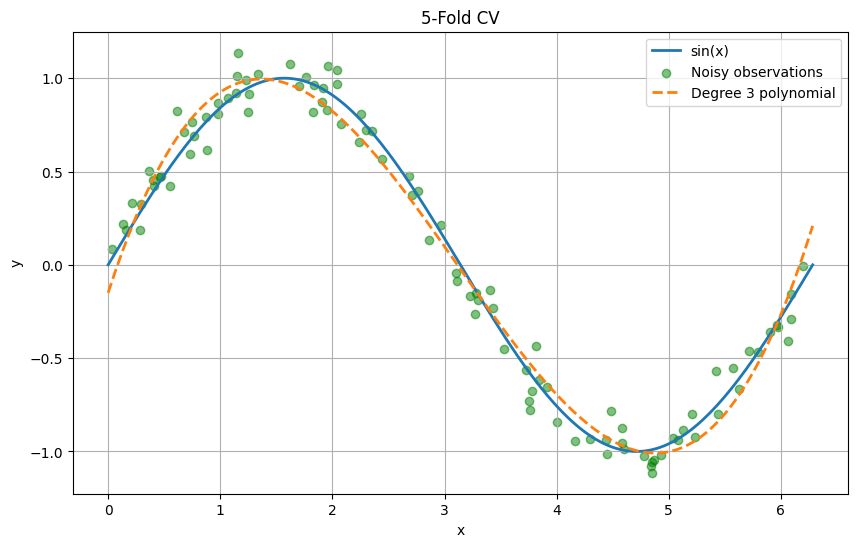

In [12]:
plt.figure(figsize=(10, 6))
x_plot = np.linspace(0, 2*np.pi, 200)  
plt.plot(x_plot, np.sin(x_plot), label='sin(x)', linewidth=2)
plt.scatter(x, y, color='green', alpha=0.5, label='Noisy observations')


coeffs = Coefficient_val(x, y, best_degree)
y_pred = np.array([True_Value_func(coeffs, xi) for xi in x_plot])
plt.plot(x_plot, y_pred, '--', label=f'Degree {best_degree} polynomial', linewidth=2)

plt.legend()
plt.title("5-Fold CV")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()